# Predicting Electricity consumption

## Team
Dmitri Rozgonjuk <br>
Eerik Sven Puudist <br>
Triin Pohla 
Andri Hõbemägi <br>

## 0. Setup
Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data Import and a Quick Glimpse

In [2]:
# Download data from kaggle
#!kaggle competitions download -c predict-electricity-consumption

# Unzip the data
#!unzip predict-electricity-consumption.zip

In [3]:
# Import the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_submission = pd.read_csv("sample_submission.csv")

In [4]:
df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


In [5]:
df_test.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price
0,2022-08-25 00:00:00+03:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533
1,2022-08-25 01:00:00+03:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492
2,2022-08-25 02:00:00+03:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853
3,2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947
4,2022-08-25 04:00:00+03:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192


## 2. Extracting Features from the `time` Feature
Before we start extracting information from the `time` variable, we first need to convert the column to a `datetime64` type in pandas. Then, we should look into the time range of each data set. The goal is to see what were the date ranges (for extracting additional features, e.g., holidays), and to see if the test data immediately follows training data in time sequence.

In [6]:
df_train['time'] = pd.to_datetime(df_train['time'], utc=True)
df_test['time'] = pd.to_datetime(df_test['time'], utc=True)
df_submission['time'] = pd.to_datetime(df_submission['time'], utc=True)

In [7]:
print(f"The range of training data: {df_train['time'].min(), df_train['time'].max()}")
print()
print(f"The range of test data: {df_test['time'].min(), df_test['time'].max()}")

The range of training data: (Timestamp('2021-08-31 21:00:00+0000', tz='UTC'), Timestamp('2022-08-24 20:00:00+0000', tz='UTC'))

The range of test data: (Timestamp('2022-08-24 21:00:00+0000', tz='UTC'), Timestamp('2022-08-31 20:00:00+0000', tz='UTC'))


Ok, from this we see that, indeed, the training and test data are sequential. The training dates range from 31.08.2021 to 24.08.2022, while the range for test data is 24.08.2022 until 31.08.2022. Now, we will also download the Estonian holidays table and keep only the rows for the relevant time period. (Let's also save the holidays table in case we need to use this in the future.)

In [8]:
# NOTE! Also possible to fetch the holidays info via 'holidays' Python module

# Fetch the list of holidays from 'riigipühad.ee'
r = requests.get('https://riigipühad.ee/?output=json')
json_str = json.dumps(r.json())
holidays = pd.read_json(json_str)
holidays['time'] = pd.to_datetime(holidays['date'], utc=True)
holidays['date'] = holidays['time'].dt.date
holidays.rename(columns= {'kind_id':'h_type'}, inplace = True) # rename the col for later clarity
# holidays.to_csv('estonian_holidays.csv', index=False)

# Keep only the relevant rows
holidays = holidays[(holidays['date'] >= df_train['time'].dt.date.min()) & 
                    (holidays['date'] <= df_test['time'].dt.date.max())].reset_index(drop = True)
holidays.head()
# holidays['kind_id'].value_counts() # count the unique holiday types

# Create the mini df for merge
df_holidays = holidays.loc[:, ['date', 'h_type']]
df_holidays['is_holiday'] = np.full(len(df_holidays), 1)
df_holidays.head()

# might be useful for calendar data: https://towardsdatascience.com/holiday-calendars-with-pandas-9c01f1ee5fee

,date,h_type,is_holiday
0,2021-09-12,3,1
1,2021-09-22,3,1
2,2021-10-16,3,1
3,2021-11-02,3,1
4,2021-11-14,3,1


In [9]:
# Fill the NAs with the average of previous and next value in time-series
df_train['consumption'] = df_train['consumption'].interpolate()

Below, we are creating a helper function that extract date-related information

In [10]:
### 2.1. Create meaningful variables from 'time'
def wrangle_dates(df):
    """A function that turns a pd.Series datetime column to several more granular columns
    Args:
        df (pandas DataFrame): input data (e.g., df_train or df_test)
    """
    # Date variables
    df['date'] = df['time'].dt.date # date
    df['year'] = df['time'].dt.year # year
    df['month'] = df['time'].dt.month # month
    df['dow'] = df['time'].dt.dayofweek # day-of-week
    
    # Time variables
    ## Only the 'hour' varies, hence no neebd for 'time' and 'minute'
    df['hour'] = df['time'].dt.hour # hour
    
    # Season
    conditions = [
        (df['month'].isin(np.arange(3,6))), (df['month'].isin(np.arange(6,9))), 
        (df['month'].isin(np.arange(9,12))), (df['month'].isin(np.arange(1,3))), (df['month'] == 12)]
    choices = ['Spring','Summer', 'Autumn', 'Winter', 'Winter']
    df['season'] = np.select(conditions, choices)
    
    # Remove the datetime variable
    # df = df.drop(columns = ['datetime'], axis = 1)
    

In [11]:
wrangle_dates(df_train)

# Add holidays info
df_train = df_train.merge(df_holidays, on = 'date', how = 'left')
df_train['h_type'] = df_train['h_type'].fillna(0).astype(int)
df_train['is_holiday'] = df_train['is_holiday'].fillna(0).astype(int)
df_train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,el_price,consumption,date,year,month,dow,hour,season,h_type,is_holiday
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,...,0.09016,0.577,2021-08-31,2021,8,1,21,Summer,0,0
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,...,0.09251,0.594,2021-08-31,2021,8,1,22,Summer,0,0
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,...,0.08890,0.685,2021-08-31,2021,8,1,23,Summer,0,0
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,...,0.08735,1.016,2021-09-01,2021,9,2,0,Autumn,0,0
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,...,0.08688,0.677,2021-09-01,2021,9,2,1,Autumn,0,0


In [12]:
wrangle_dates(df_test)

# Add holidays info
df_test = df_test.merge(df_holidays, on = 'date', how = 'left')
df_test['h_type'] = df_test['h_type'].fillna(0).astype(int)
df_test['is_holiday'] = df_test['is_holiday'].fillna(0).astype(int)
df_test.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,date,year,month,dow,hour,season,h_type,is_holiday
0,2022-08-24 21:00:00+00:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533,2022-08-24,2022,8,2,21,Summer,0,0
1,2022-08-24 22:00:00+00:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492,2022-08-24,2022,8,2,22,Summer,0,0
2,2022-08-24 23:00:00+00:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853,2022-08-24,2022,8,2,23,Summer,0,0
3,2022-08-25 00:00:00+00:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947,2022-08-25,2022,8,3,0,Summer,0,0
4,2022-08-25 01:00:00+00:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192,2022-08-25,2022,8,3,1,Summer,0,0


Energy consumption across various time metrics

In [13]:
def hourly_consumption_hmap(grouping_var, title):
    df = df_train.loc[:, [grouping_var, 'hour', 'consumption']].\
    groupby([grouping_var, 'hour']).mean('consumption').reset_index().\
    pivot('hour', grouping_var, 'consumption')
    
    # Plot
    sns.heatmap(df)
    plt.title(f'Average Energy Consumption ({title} x Time of Day)')
    plt.show();

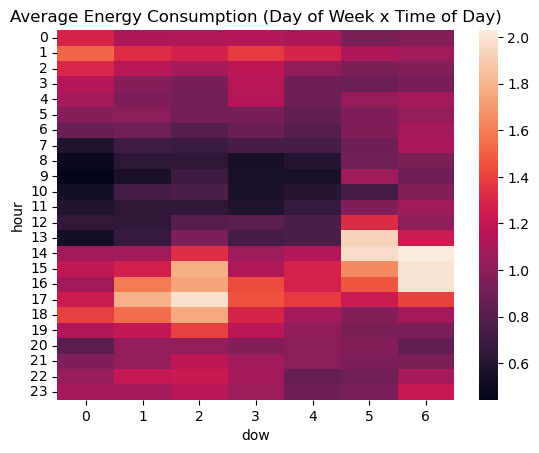

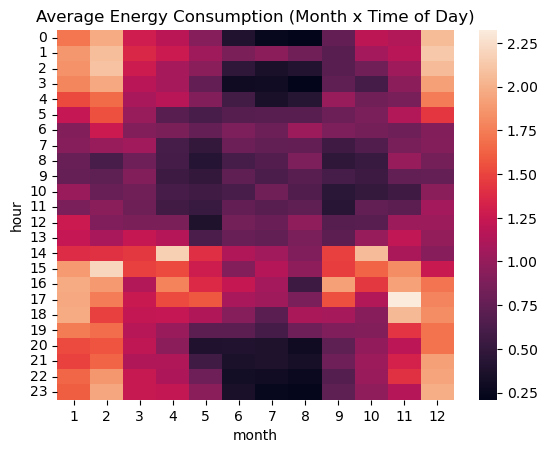

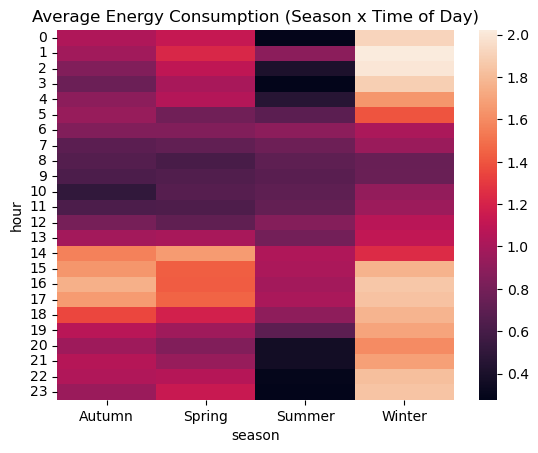

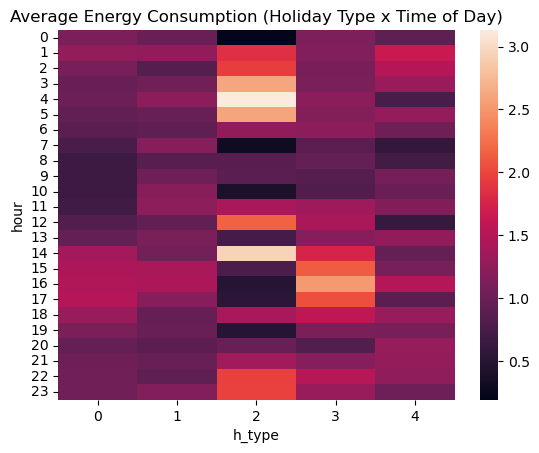

In [14]:
hourly_consumption_hmap('dow', 'Day of Week')
hourly_consumption_hmap('month', 'Month')
hourly_consumption_hmap('season', 'Season')
hourly_consumption_hmap('h_type', 'Holiday Type')

In [15]:
# Separate X features and target
y_train =  df_train['consumption']
X_train = df_train.drop(columns = ['consumption'])
X_test = df_test

In [16]:
print(f'Train data dimensions: {X_train.shape}')
X_train.head()

Train data dimensions: (8592, 20)


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,date,year,month,dow,hour,season,h_type,is_holiday
0,2021-08-31 21:00:00+00:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,2021-08-31,2021,8,1,21,Summer,0,0
1,2021-08-31 22:00:00+00:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,2021-08-31,2021,8,1,22,Summer,0,0
2,2021-08-31 23:00:00+00:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,2021-08-31,2021,8,1,23,Summer,0,0
3,2021-09-01 00:00:00+00:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,2021-09-01,2021,9,2,0,Autumn,0,0
4,2021-09-01 01:00:00+00:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,2021-09-01,2021,9,2,1,Autumn,0,0


In [17]:
print(f'Test data dimensions: {X_test.shape}')
X_test.head()

Test data dimensions: (168, 20)


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,date,year,month,dow,hour,season,h_type,is_holiday
0,2022-08-24 21:00:00+00:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,0.25533,2022-08-24,2022,8,2,21,Summer,0,0
1,2022-08-24 22:00:00+00:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,0.19492,2022-08-24,2022,8,2,22,Summer,0,0
2,2022-08-24 23:00:00+00:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,0.18853,2022-08-24,2022,8,2,23,Summer,0,0
3,2022-08-25 00:00:00+00:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,0.19947,2022-08-25,2022,8,3,0,Summer,0,0
4,2022-08-25 01:00:00+00:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,0.21192,2022-08-25,2022,8,3,1,Summer,0,0


In [18]:
y_train.describe()

count    8592.000000
mean        1.046376
std         1.094988
min         0.000000
25%         0.363000
50%         0.811500
75%         1.366000
max        10.381000
Name: consumption, dtype: float64

## Predicting Energy Consumption

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### The ARIMA approach
For this approach, we used the [helpful tutorial](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7) for guidance.

For this approach, we need to take into account the three components of a time series:
* **Trend**: the movement of data over a larger time interval
* **Seasonality**: variance within smaller time intervals
* **Noise**: random variations

Before building the model, we need to ensure the stationarity of the time series. In other words, the average od the time series should not be a function of time.


Let's plot the original time series in training data

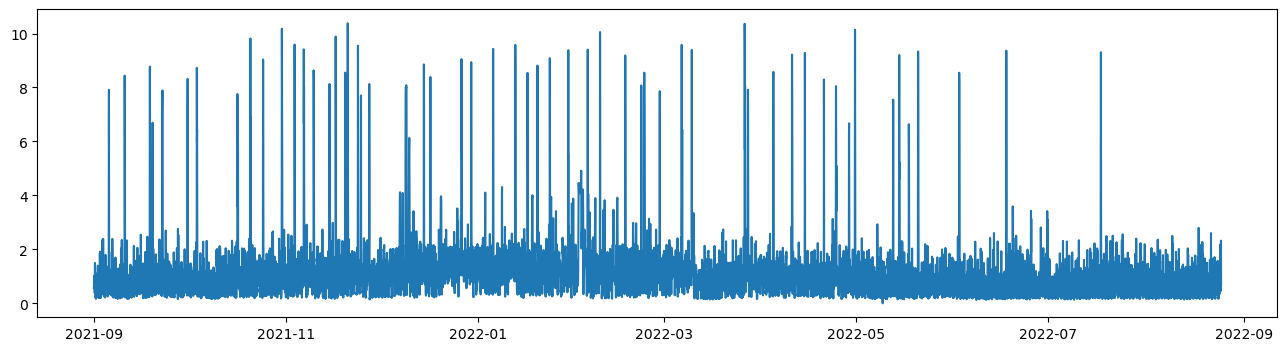

In [20]:
plt.figure(figsize=[16,4])
plt.plot(X_train['time'], y_train)
plt.show();

Yikesy-spikesy. Let's test the data for stationarity.

In [21]:
result = adfuller(y_train)
print('ADF Statistic: {}'.format(result[0]))

print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -11.365758604519176
p-value: 9.235672127588169e-21
Critical Values:
	1%: -3.431113630713319
	5%: -2.8618774731292778
	10%: -2.56694963202479


To this end, the data seem to be stationary.

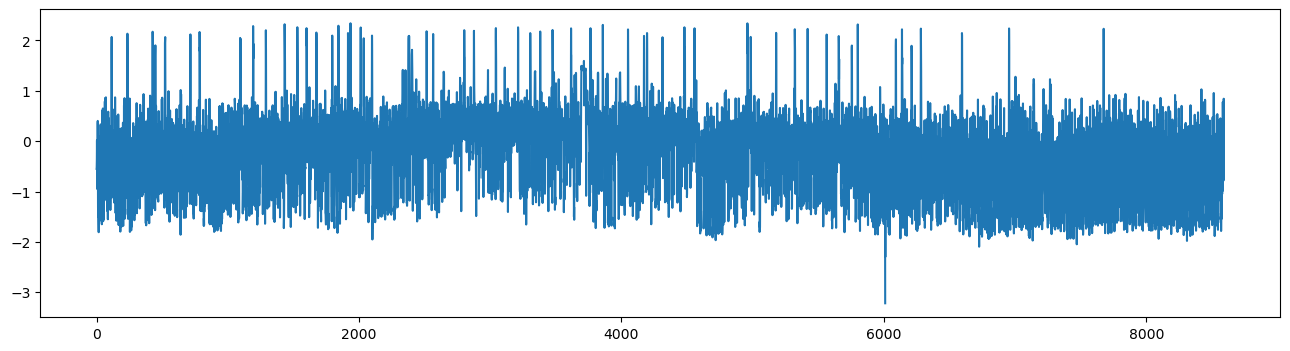

In [22]:
np.seterr(divide = 'ignore') 
df_log = np.log(y_train)

plt.figure(figsize=[16,4])
plt.plot(df_log)
plt.show();